In [6]:
import os
import sys
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Add project root to path to import config
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

from config.constants import MODELS_DIR, RAW_IMAGE_DATA_DIR, PROCESSED_IMAGE_DATA_DIR, CLEANED_IMAGE_DATA_DIR
from utils.image_processing import preprocess_image, get_image_generator

## 1. Load Model & Class Indices

In [2]:
MODEL_PATH = MODELS_DIR / 'resnet50_instrument_classifier.keras'
INDICES_PATH = MODELS_DIR / 'image_class_indices.pkl'

# 1. Load Model
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}. Run 02_Model_Training.ipynb first!")

model = load_model(MODEL_PATH)
print("✅ Model loaded successfully.")

# 2. Load Class Indices
if not os.path.exists(INDICES_PATH):
    raise FileNotFoundError(f"Class indices not found at {INDICES_PATH}. Run 02_Model_Training.ipynb first!")

with open(INDICES_PATH, 'rb') as f:
    class_indices = pickle.load(f)

# Invert the dictionary to map Index -> Class Name
index_to_class = {v: k for k, v in class_indices.items()}
print(f"✅ Loaded {len(index_to_class)} classes.")

2025-12-13 18:13:30.517865: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


✅ Model loaded successfully.
✅ Loaded 30 classes.


## 2. Quantitative Evaluation
We will recreate the test set generator to evaluate the model on the full test split.


In [3]:
# 1. Load the full dataset CSV
csv_path = PROCESSED_IMAGE_DATA_DIR / "instruments.csv"
df = pd.read_csv(csv_path)

# 2. Recreate the Train/Test split
# We must use the SAME random_state as in training to ensure the test set is actually unseen
_, test_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['label'], 
    random_state=42
)

print(f"Test Set Size: {len(test_df)} images")

# 3. Create Data Generator
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
datagen = get_image_generator()

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=CLEANED_IMAGE_DATA_DIR,
    x_col="filename",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False # IMPORTANT: Don't shuffle so predictions align with labels
)


Test Set Size: 1019 images
Found 1019 validated image filenames belonging to 30 classes.


In [4]:
# 4. Evaluate Loss and Accuracy
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")


2025-12-13 18:13:37.829324: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-13 18:13:38.060945: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 106463232 exceeds 10% of free system memory.
2025-12-13 18:13:38.184535: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-13 18:13:38.381706: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-13 18:13:38.749725: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.


32/32 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.9617 - loss: 0.1919
Test Loss: 0.1919
Test Accuracy: 96.17%


Generating predictions for Confusion Matrix...
32/32 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step


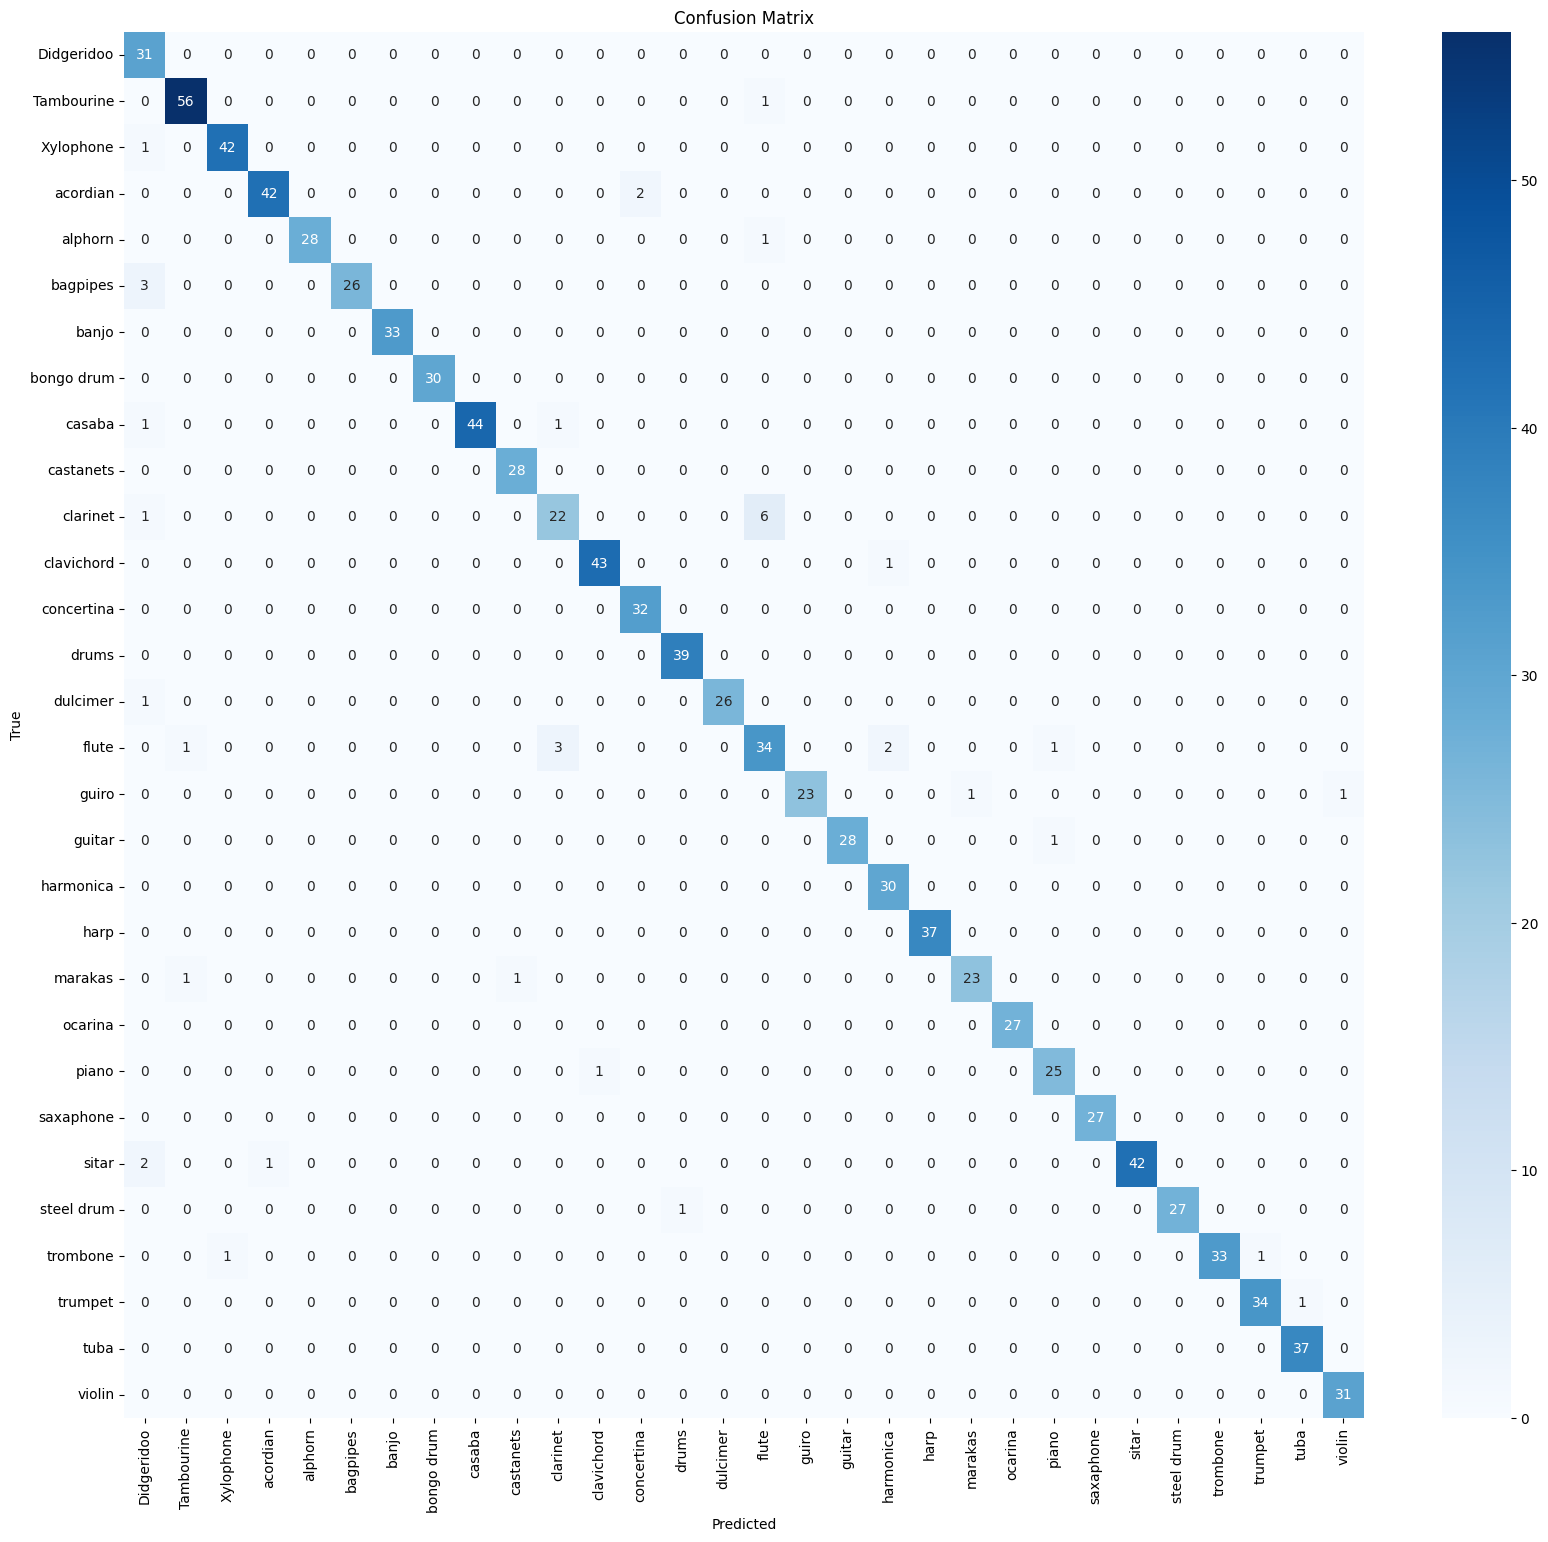


Classification Report:
              precision    recall  f1-score   support

  Didgeridoo       0.78      1.00      0.87        31
  Tambourine       0.97      0.98      0.97        57
   Xylophone       0.98      0.98      0.98        43
    acordian       0.98      0.95      0.97        44
     alphorn       1.00      0.97      0.98        29
    bagpipes       1.00      0.90      0.95        29
       banjo       1.00      1.00      1.00        33
  bongo drum       1.00      1.00      1.00        30
      casaba       1.00      0.96      0.98        46
   castanets       0.97      1.00      0.98        28
    clarinet       0.85      0.76      0.80        29
  clavichord       0.98      0.98      0.98        44
  concertina       0.94      1.00      0.97        32
       drums       0.97      1.00      0.99        39
    dulcimer       1.00      0.96      0.98        27
       flute       0.81      0.83      0.82        41
       guiro       1.00      0.92      0.96        25
   

In [7]:
# 5. Confusion Matrix & Classification Report
print("Generating predictions for Confusion Matrix...")
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Get class names from the generator to ensure correct order
class_names = list(test_generator.class_indices.keys())

# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## 2. Define Prediction Function

In [8]:
def predict_instrument(image_path, model, index_to_class):
    """
    Predicts the instrument class for a given image.
    """
    # 1. Preprocess
    # This function (from utils) resizes to 224x224 and applies ResNet preprocessing
    img_tensor = preprocess_image(image_path)
    
    if img_tensor is None:
        return "Error", 0.0

    # 2. Predict
    predictions = model.predict(img_tensor, verbose=0)
    
    # 3. Decode
    predicted_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_index]
    predicted_label = index_to_class[predicted_index]
    
    return predicted_label, confidence

def display_prediction(image_path, true_label=None):
    """
    Runs prediction and displays the image with the result.
    """
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    # Predict
    pred_label, conf = predict_instrument(image_path, model, index_to_class)
    
    # Load image for display (OpenCV reads as BGR, convert to RGB)
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    
    title_text = f"Pred: {pred_label} ({conf*100:.1f}%)"
    if true_label:
        title_text += f"\nTrue: {true_label}"
        
    # Color title green if correct, red if wrong (if true label is known)
    color = 'green' if true_label and true_label == pred_label else 'black'
    if true_label and true_label != pred_label:
        color = 'red'
        
    plt.title(title_text, color=color, fontsize=14)
    plt.show()

## 3. Test on Sample Images
We will pick a few random images from the raw test set to verify the model.


Testing image: 1.jpg


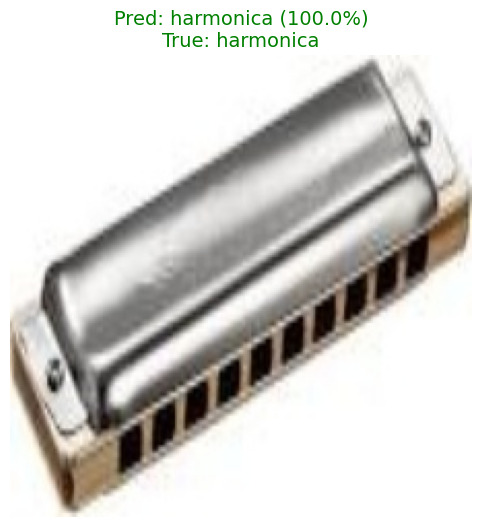


Testing image: 3.jpg


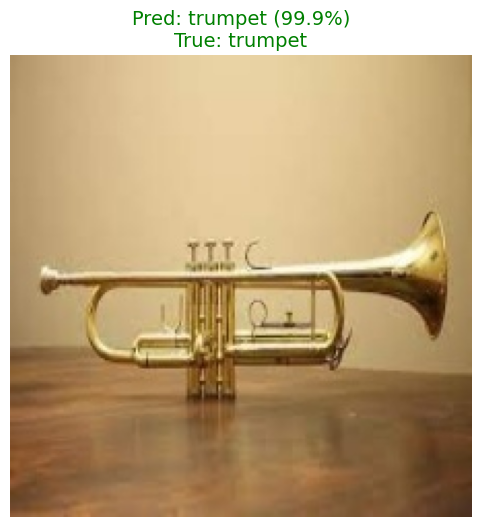


Testing image: 4.jpg


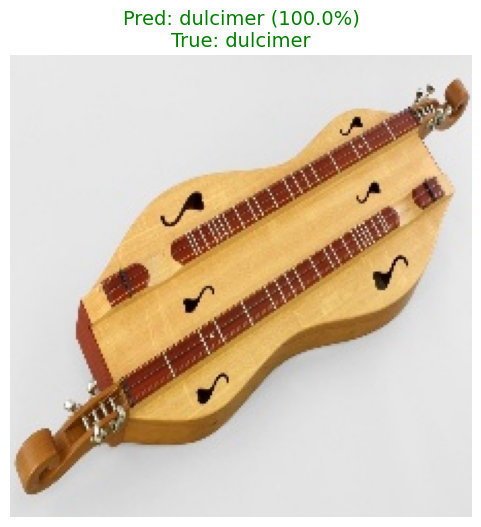


Testing image: 2.jpg


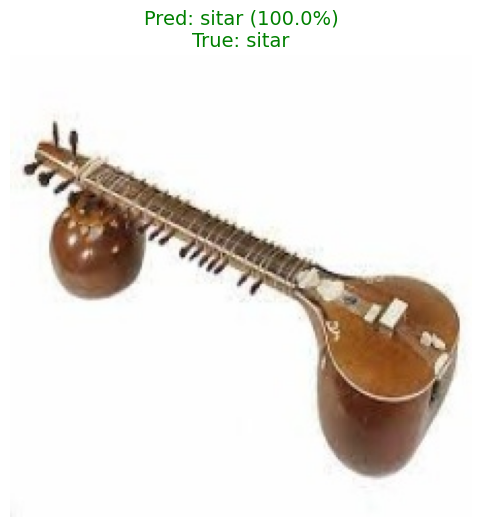


Testing image: 3.jpg


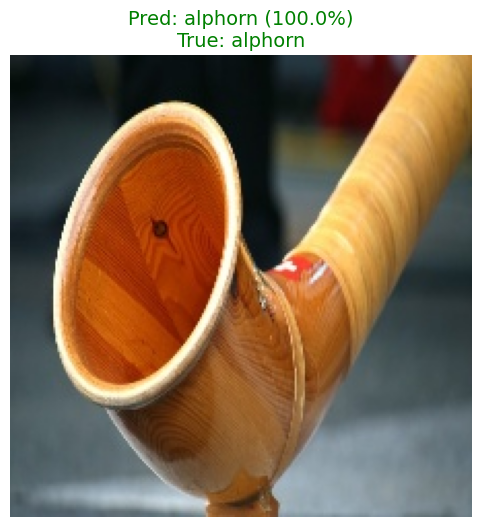

In [9]:
import random

# Define the test directory
TEST_DIR = RAW_IMAGE_DATA_DIR / "test"

# Get list of classes (folders) in test directory
test_classes = [d for d in os.listdir(TEST_DIR) if os.path.isdir(TEST_DIR / d)]

# Pick 5 random classes
random_classes = random.sample(test_classes, 5)

for class_name in random_classes:
    class_dir = TEST_DIR / class_name
    images = os.listdir(class_dir)
    
    if images:
        # Pick a random image from this class
        img_name = random.choice(images)
        img_path = class_dir / img_name
        
        print(f"\nTesting image: {img_name}")
        display_prediction(img_path, true_label=class_name)

## 4. Test on External Image

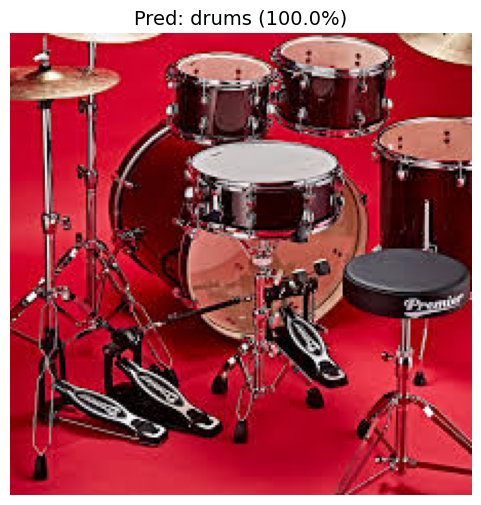

In [18]:
# Example:
custom_image_path = "/home/insane.beggar/Downloads/images (4).jpeg"
display_prediction(custom_image_path)